In [1]:
#Mounting Drive
from google.colab import drive 
drive.mount('/content/drive')

#Imports

import matplotlib.pyplot as plt
from PIL import Image as im
from skimage.color import rgb2gray
import cv2 as cv

from google.colab import files
import os
import math
import random

import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Activation,Dropout,Flatten
from keras.preprocessing.image import ImageDataGenerator
import keras.backend as K


Mounted at /content/drive


In [2]:
#Defining Parameters for Image Conversion
scale = 4.5 #Scales the radii of the diffraction profiles (large scale increases space between 'rings')
resolution = 150#150#126*2 #Determines image resolution
noise_level = 0.2

In [3]:
#Used for classification task
def generate_one_hot_vecs(num):
  #Generating one hot vectors for labels
  one_hot_vecs = []
  for i in range(0,num):
    one_hot_vec =[0] * num
    one_hot_vec[i] = 1
    one_hot_vecs.append(one_hot_vec)
  return one_hot_vecs

In [4]:
#Open and processes data in all files in a given directory
#Returns one list of radii and another of intensities


def retrieve_data(directory="/content/drive/MyDrive/Bismuth_Data_Processed/Bismuth profiles"):
  #Creating an array of file names for all Bi files 
  files_to_open = []
  """
  for val in range(0,11,1):
    #print(val/10)
    file_name = directory + str(val/10) + ".txt" 
    files_to_open.append(file_name)
  """
  #Opening files and processing data into lists of radii and intensities 

  radii = [] 
  intensities = []
  for subdirectories, directories, files in os.walk("/content/drive/MyDrive/Bismuth_Data_Processed/Bismuth profiles"):
    for file_name in files:
      #print(subdirectories + os.path.sep + file_name)
      file = open(subdirectories + os.path.sep + file_name, "r")
      array_vals = []
      for line in file:
        data_point = line.split() #X and Y values are separated by a space

        array_vals.append([scale*math.tan(math.radians(float(data_point[0]))/2),float(data_point[1])]) #converts angles into radii  
      
      radius,intensity = zip(*array_vals) #Unzipping array of [x_values,y_values] into list of x_values and y_values

      radii.append(radius)
      intensities.append(intensity)
        
  for i in range(0,len(radii)):
    plt.plot(radii[i],intensities[i])

  return radii,intensities

def add_multiplicative_noise(input_img):
  noise = 1+(noise_level*np.random.randn(resolution,resolution))
  noisy_img = input_img*noise
  return noisy_img

In [25]:
#Converts Radii-Intensity data into Diffraction Patterns
#Returns 2D array in which each element is: [diffraction pattern, label]

def generate_diffraction_patterns(radii,intensities,one_hot_vecs,invert=False,num_augmentations=3,num_img_to_generate=5):

  #This code generates a two-part circular mask 
  #This mask obscures all points greater than a distance of 'curr_rad' and less than a distance of 'prev_rad'
  #This creates a circle, the radius of which depends on the resolution of the angle data
  #This mask is applied to a white image in order to generate a fully white circle 
  #source: https://stackoverflow.com/questions/44865023/how-can-i-create-a-circular-mask-for-a-numpy-array
  #Added an invert option because it looks cool

  images = [] #images will be a list of [diffraction patterns, labels]

  #Setting up a (resolution,resolution) sized array for the mask
  #Ogrid is used to setup a row and column vector of values ranging from 0 to resolution

  Y,X = np.ogrid[:resolution,:resolution]
  centre_val = resolution/2

  #The values stored in each vector are squared and the vectors are added (using broadcasting)
  #The value at each point of the resulting array is the 'distance' between that point and the centre
  dist_from_center = np.sqrt((X-centre_val)**2+(Y-centre_val)**2)

  #white image used to generate white circles
  #array_ones = np.ones((resolution,resolution))

  datagen = ImageDataGenerator(
    #zoom_range = 0.1,
    #rotation_range=180,
    horizontal_flip=True,
    vertical_flip=True,
    )
  for i in range(0,len(radii)): #iterates through all diffraction profiles
    
    #creates a 'base image' for the background of the image
    """
    if invert:
      base_img = np.ones((resolution,resolution))*255
    else:
      base_img = np.zeros((resolution,resolution))
    """
    
    base_img = np.zeros((resolution,resolution))
    radius = radii[i]
    intensity = intensities[i]
    
    #Scaling the radii of each diffraction pattern
    #This ensures that the smallest radii rings (the brightest rings) have a radius equal to 8.5% of the image's width/height
    min_rad = radius[0]
    radius_adjustment_value = (resolution/2)*0.17/min_rad

    prev_rad = radius[0]*radius_adjustment_value
    max_intensity = max(intensity)
    for j in range(0,len(radius)):         
      curr_rad = radius[j]*radius_adjustment_value

      #Defining the two-part mask
      mask = (dist_from_center <= curr_rad) & (dist_from_center > prev_rad)      
      white_image = np.ones((resolution,resolution)) #np.copy(array_ones)
      
      #applies mask to white image
      white_image[~mask]=0
      
      #normalizing by setting uiso_0 images equal to OFF images in lab data
      base_img += white_image*intensity[j]#*8000/max(intensities[0])
      prev_rad = curr_rad

    base_img = base_img*8000/90247000
    max_image_brightness = max(np.ndarray.flatten(base_img))

    # Setting up stopper + bright spot
    X_centered = X - resolution/2
    Y_centered = Y - resolution/2

    #making x/y square arrays
    lin_combination_image = Y_centered+X_centered

    X_square = lin_combination_image-Y_centered
    Y_square = X_centered-lin_combination_image

    #determining distance of each point in array from centre (this will be used in bright spot's the mask)
    dist_from_center = (np.sqrt((X-centre_val)**2+(Y-centre_val)**2))

    max_dist = max(np.ndarray.flatten(dist_from_center))

    #normalizes distance values
    normalized_bright_spot = (max_dist-dist_from_center)/max_dist

    #defines mask for the bright spot in the middle (with a dark spot because of the stopper)
    bright_spot_mask = (normalized_bright_spot>0.955) & (normalized_bright_spot<0.97)

    #applies mask
    normalized_bright_spot[~bright_spot_mask] = 0

    #Brightens spot based on rest of image
    normalized_bright_spot *= max_image_brightness

    #Defining mask for stopper's wire

    lin_eq_square =Y_square + 4*X_square #Defines the stopper wire's equation as b = Y + 4*X , with b ranging from +-0.04*resolution in order to give the wire some thickness
    quadrant_mask = (X_square>0) #Only want the stopper's wire in the 4th quadrant, so we limit X > 0
    wire_mask = (lin_eq_square<resolution*0.04) & (lin_eq_square>-resolution*0.04)         

  
    #applies both masks to white image to create image of stopper
    
    #Subtracts image of stopper from the base image, and adds the bright spot in the middle
    
    #base_img = np.clip(base_img - white_image + normalized_bright_spot,0,max_image_brightness)

    
    
    mean = resolution/2
    div_param = 1
    mult_param = 82500
    exp_param = 2
    stdev = 0.425*resolution

    #gaussian_base = np.clip(mult_param*(1/(((X-mean)/div_param)**(2)+((Y-mean)/div_param)**(2)))**(1/exp_param),0,999999999)    
    gaussian_base = 4000*np.exp((-(X-mean)**(2)-(Y-mean)**2)/(stdev)**2)
    dist_from_center = np.sqrt((X-75)**2+(Y-75)**2)
    mask = (dist_from_center > 13)   
    gaussian_base[~mask]=0
    base_img = base_img + gaussian_base

    max_image_brightness = max(np.ndarray.flatten(base_img))
    white_image = max_image_brightness*np.ones((resolution,resolution))#
    white_image[~wire_mask]=0
    white_image[~quadrant_mask]=0
    base_img = np.clip(base_img - white_image ,0,max_image_brightness)
    
    #add multiplicative/additive noise (turned off for now)
    #base_img_noisy = add_multiplicative_noise(base_img)
    
    #Blurring and randomly translating images to generate more datapoints            
    #We'll repeat the augmentation code multiple times, each time with a different blur    
    #"""
    for augmentation in range(0,num_augmentations):
      
      max_translation = int(0.05*resolution)
      for q in range(0,30):
        M = np.float32([
        [1, 0, random.randint(-max_translation,max_translation)],
        [0, 1, random.randint(-max_translation,max_translation)]
        ])    
        new_image = cv.warpAffine(base_img, M, (resolution,resolution))

        blurry_img_expanded=np.expand_dims(np.expand_dims(new_image,-1),0)

        num_images_generated = 0
        for augmented_image in datagen.flow(blurry_img_expanded):
          if num_images_generated < num_img_to_generate:
            num_images_generated+=1
            reshaped_augmented_image = np.reshape(augmented_image,(resolution,resolution)) 

            reshaped_augmented_image_blurry = cv.GaussianBlur(reshaped_augmented_image,(5,5),0.3+random.uniform(-0.3, 0.3))
            
            if invert:
              max_blurry_image_brightness = max(np.ndarray.flatten(reshaped_augmented_image_blurry))
              inverted_image = max_blurry_image_brightness - reshaped_augmented_image_blurry              
              images.append([inverted_image,round(float(i/(len(radii)-1)),2)])
            else:              
              images.append([reshaped_augmented_image_blurry/12000,round(float(i/(len(radii)-1)),2)])
              
          else:
            break  
    #"""         
  #Shuffles dataset
  random.shuffle(images)
  return images

45450
0.51


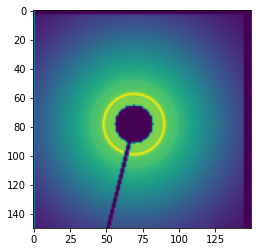

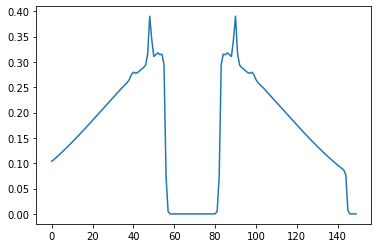

0.33


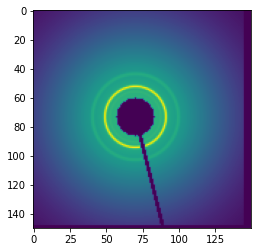

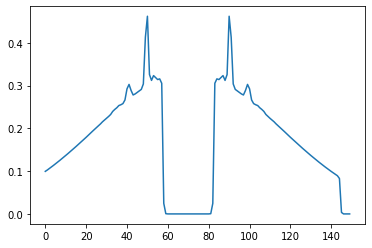

0.78


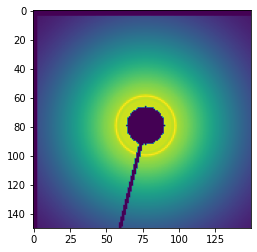

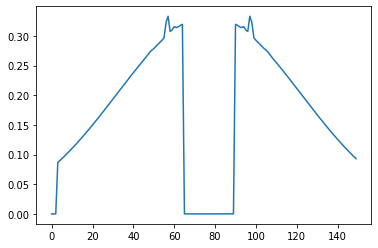

0.81


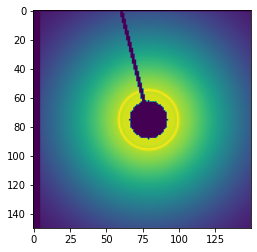

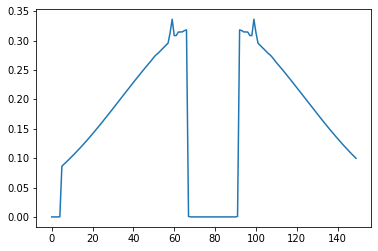

0.67


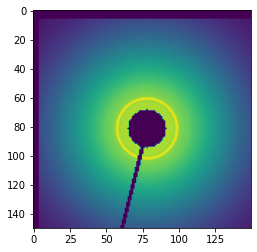

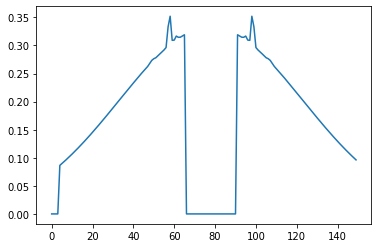

0.49


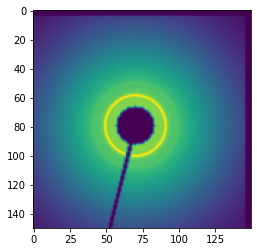

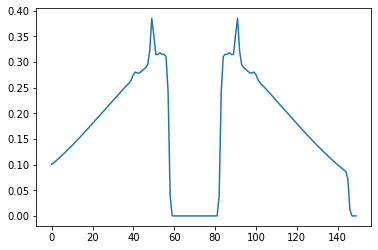

0.61


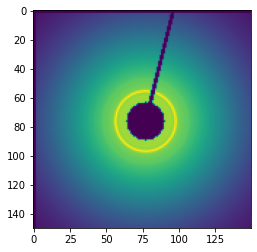

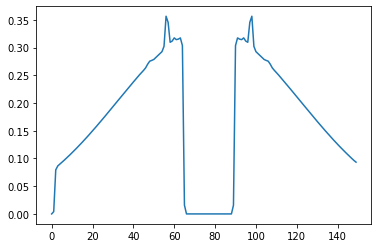

0.63


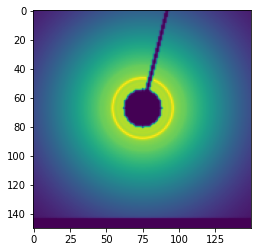

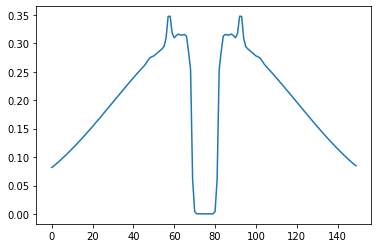

0.69


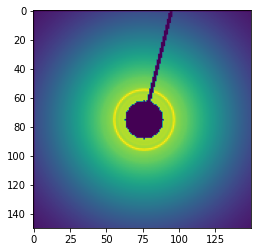

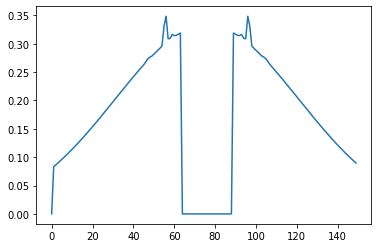

0.53


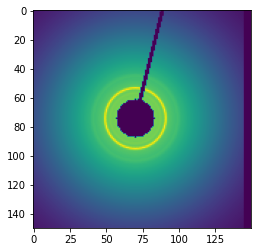

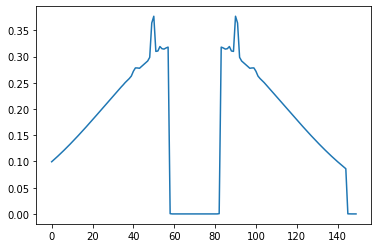

(45450, 150, 150, 1)
(45450, 1)


In [26]:
#Calling functions to generate diffraction data
radii,intensities=retrieve_data()
images = generate_diffraction_patterns(radii,intensities,False)
print(len(images))
for i in range(0,10):  
  plt.imshow(images[i][0])
  print(images[i][1])
  plt.show()
  plt.plot(images[i][0][78])
  plt.show()
  #print(images[i][0].shape)
  #print(max(np.ndarray.flatten(images[i][0])))

#Extracting and reshaping arrays of X and Y values from dataset

X,Y = zip(*images)

X_array = np.array(X).reshape(-1,int(resolution),int(resolution),1)
Y_array = np.array(Y).reshape(-1,1)

#Array shape is checked to ensure they are of equal length and of correct size
print(X_array.shape)
print(Y_array.shape)

In [32]:
#Opens files with lab data, processes the image arrays and 
def process_data(data_dir):
  Y,X = np.ogrid[:resolution,:resolution]
  centre_val = resolution/2

  dist_from_center = np.sqrt((X-78)**2+(Y-79)**2)
  mask = (dist_from_center > 13) 
  data_dict = {}
  file_name_array = []
  first_file_max_val = 12000
  for file in os.scandir(data_dir):
    #print(file.path)
    file_loc = file.path.split('Bismuth_Data_Processed')[1]

    #Lab data is stored in .npy numpy array files
    if file_loc.endswith(".npy"):      
      if 'on' in file_loc.lower():
        file_loc_cropped = file_loc.lower().strip().replace(' ','')   

        #Loading image array from file     
        img_array = np.load(file.path)[:,74:-74]
        #Converting array into image in order to crop it
        image = im.fromarray(img_array)
        #Converting image to array to append to array for neural net (not sure if this step is needed but TF can be finicky with image arrays)
        image = np.array(cv.resize(np.float32(image),(150,150)))        
        image[~mask] = 0        
        
        #determines max pixel value for the first file (for normalization)
        if len(file_name_array) == 0:
          first_file_max_val = max(np.ndarray.flatten(image))
        
        file_name_array.append(file_loc_cropped)
        data_dict[file_loc_cropped]=image/first_file_max_val
  
  print("Done! Added {} images".format(len(data_dict.values())))
  return file_name_array, data_dict

Directory name: /content/drive/MyDrive/Bismuth_Data_Processed/2021-02-16/scans/scan0/
Done! Added 11 images


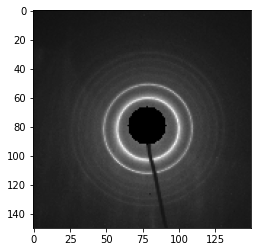

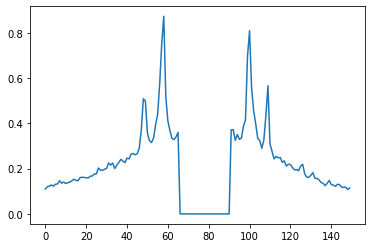

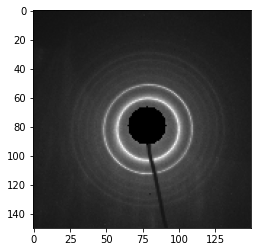

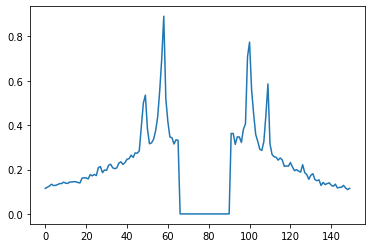

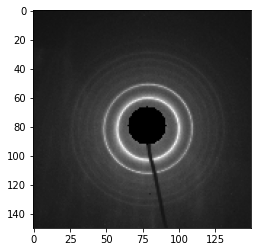

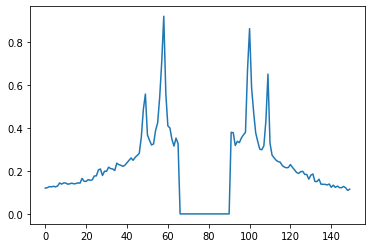

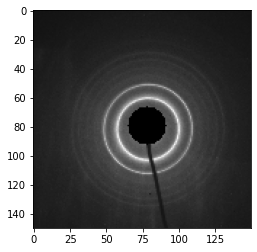

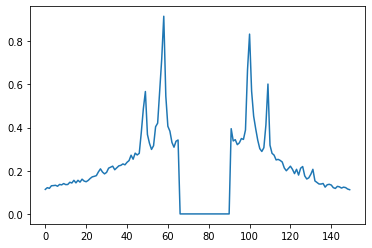

KeyboardInterrupt: ignored

In [33]:
#array of dates of scans to be opened
dates = [16]

"""
Y,X = np.ogrid[:resolution,:resolution]
centre_val = resolution/2

dist_from_center = np.sqrt((X-78)**2+(Y-79)**2)
mask = (dist_from_center > 13)      
"""
#opens scans 0-15
dirs_to_open=range(0,5)
data_dir = '/content/drive/MyDrive/Bismuth_Data_Processed/'
for date in dates:
  series_arr = []
  date = "2021-02-" + str(date) + "/scans/scan"
  for i in dirs_to_open:
    #print("----------STARTING NEW TEST------")
    scan_num = str(i)
    dir_name = data_dir + date + scan_num + "/"
    if os.path.exists(dir_name):
      print("Directory name: "+dir_name)
      file_name_array, data_dict = process_data(dir_name)
      file_name_array.sort()
      data_arr = []

      for file_name in file_name_array:
        data_arr.append([data_dict[file_name],file_name])     
        
      for i in data_arr:
        image = i[0]
        #plt.imshow(image,cmap='gray')
        #plt.show()
        #image[~mask] = 0        
        plt.imshow(image,cmap='gray')
        plt.show()
        plt.plot(image[78])
        plt.show()
     
img = images[0][0]
print(img.shape)
plt.imshow(img)
plt.show()

In [29]:
#Defining neural net

def build_cnn_model():
  cnn_model = keras.Sequential([
      keras.layers.Conv2D(filters=18,kernel_size=(5,5),activation=tf.nn.relu),           
      keras.layers.MaxPool2D(pool_size=(2, 2)),

      keras.layers.Conv2D(filters=36,kernel_size=(5,5),activation=tf.nn.relu), 
      keras.layers.MaxPool2D(pool_size=(2, 2)),

      keras.layers.Conv2D(filters=72,kernel_size=(5,5),activation=tf.nn.relu), 
      keras.layers.MaxPool2D(pool_size=(2, 2)),
      

      keras.layers.Flatten(),
      keras.layers.Dense(128, activation=tf.nn.relu),
      #keras.layers.Dropout(0.6),
      keras.layers.Dense(1)#, activation=tf.nn.softmax)
  ])
    
  return cnn_model

def compile_cnn(model,init_lr=0.001):
  initial_learning_rate = init_lr
  lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
      initial_learning_rate,
      decay_steps=300,
      decay_rate=0.96,
      staircase=True)
  model.compile(loss = 'mean_squared_error', optimizer = tf.keras.optimizers.RMSprop(learning_rate = lr_schedule), 
                  metrics = [linear_regression_equality])
  return model

def load_model(epoch_to_load,base_type):
  model = build_cnn_model()
  model = compile_cnn(model,0.0007)
  if base_type == 0:
    model.load_weights("/content/drive/MyDrive/Bismuth_Data_Processed/CNN_weights_normal_{}.ckpt".format(epoch_to_load)).expect_partial()
  elif base_type == 1:
    model.load_weights("/content/drive/MyDrive/Bismuth_Data_Processed/CNN_weights_inv_sq_{}.ckpt".format(epoch_to_load)).expect_partial()      
  else:
    model.load_weights("/content/drive/MyDrive/Bismuth_Data_Processed/CNN_weights_unspecified_fn_{}.ckpt".format(epoch_to_load)).expect_partial()    
  return model


"""
These metrics check the accuracy of the network. 
The second metric (which has a larger allowed error) determines whether the network's prediction is 'in the ballpark'
"""
accepted_diff = 0.0005 
def linear_regression_equality(y_true, y_pred):
    diff = K.abs(y_true-y_pred)
    return K.mean(K.cast(diff < accepted_diff, tf.float32))

what epoch to load?0
Model has been compiled
how many epochs to train?45
-------------STARTING EPOCH 1-------------
1364/1364 [==============================] - 16s 11ms/step - loss: 0.1010 - linear_regression_equality: 0.0109 - val_loss: 3.7422e-04 - val_linear_regression_equality: 0.0206
-------------STARTING EPOCH 2-------------
1364/1364 [==============================] - 16s 11ms/step - loss: 7.0083e-04 - linear_regression_equality: 0.0267 - val_loss: 1.7565e-04 - val_linear_regression_equality: 0.0274


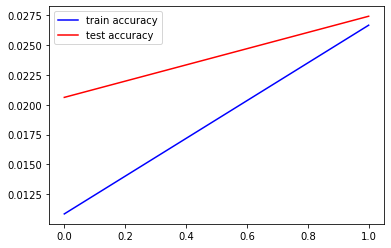

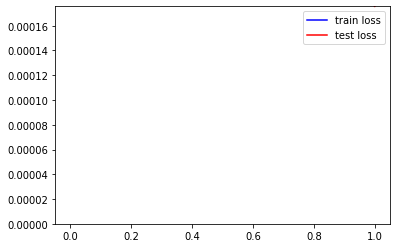

-------------STARTING EPOCH 3-------------
1364/1364 [==============================] - 15s 11ms/step - loss: 2.5621e-04 - linear_regression_equality: 0.0378 - val_loss: 1.2401e-04 - val_linear_regression_equality: 0.0248


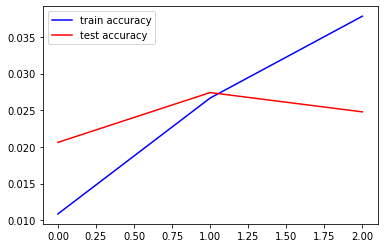

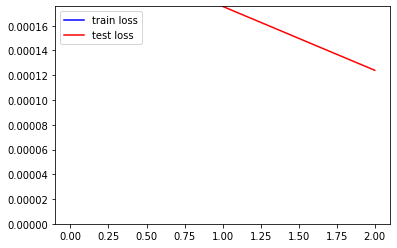

-------------STARTING EPOCH 4-------------
1364/1364 [==============================] - 15s 11ms/step - loss: 1.4257e-04 - linear_regression_equality: 0.0476 - val_loss: 3.3261e-04 - val_linear_regression_equality: 0.0496


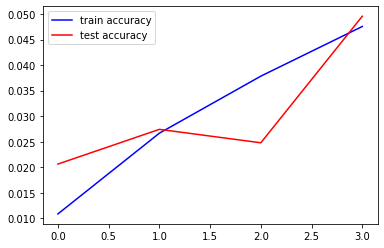

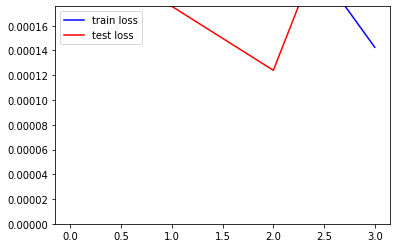

-------------STARTING EPOCH 5-------------
1364/1364 [==============================] - 15s 11ms/step - loss: 8.9950e-05 - linear_regression_equality: 0.0563 - val_loss: 4.2556e-05 - val_linear_regression_equality: 0.0294


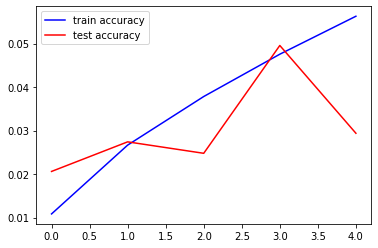

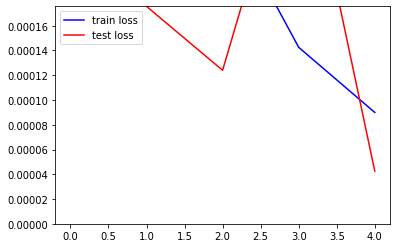

-------------STARTING EPOCH 6-------------
1364/1364 [==============================] - 15s 11ms/step - loss: 5.9004e-05 - linear_regression_equality: 0.0701 - val_loss: 8.6886e-06 - val_linear_regression_equality: 0.1640


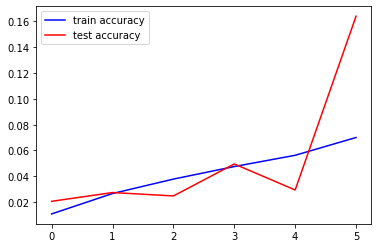

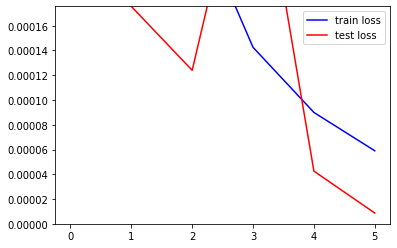

-------------STARTING EPOCH 7-------------
1364/1364 [==============================] - 15s 11ms/step - loss: 4.0518e-05 - linear_regression_equality: 0.0849 - val_loss: 1.1443e-05 - val_linear_regression_equality: 0.1362


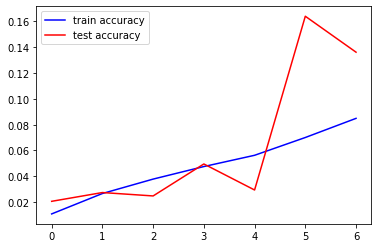

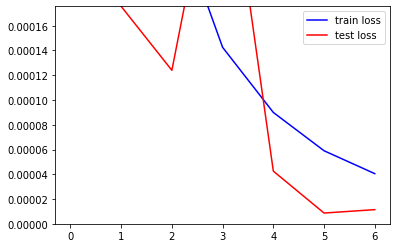

-------------STARTING EPOCH 8-------------
1364/1364 [==============================] - 15s 11ms/step - loss: 2.7328e-05 - linear_regression_equality: 0.1006 - val_loss: 1.1695e-05 - val_linear_regression_equality: 0.1316


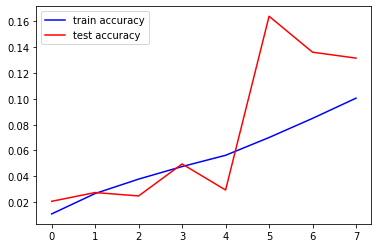

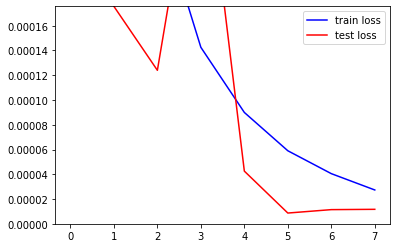

-------------STARTING EPOCH 9-------------
1364/1364 [==============================] - 15s 11ms/step - loss: 1.9241e-05 - linear_regression_equality: 0.1171 - val_loss: 1.4646e-05 - val_linear_regression_equality: 0.0855


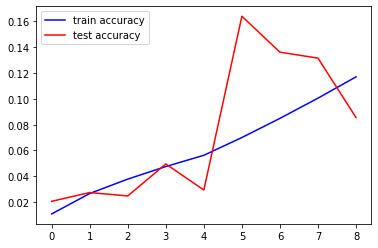

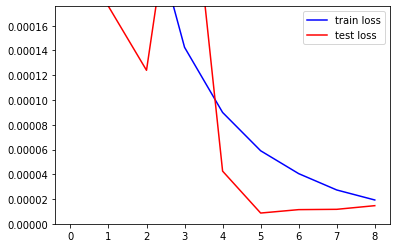

-------------STARTING EPOCH 10-------------
1364/1364 [==============================] - 15s 11ms/step - loss: 1.3911e-05 - linear_regression_equality: 0.1320 - val_loss: 7.4315e-06 - val_linear_regression_equality: 0.1502
SAVING NETWORK


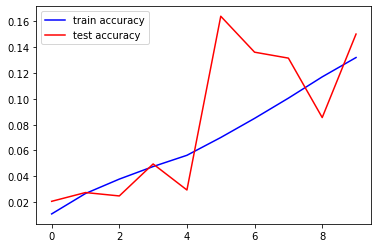

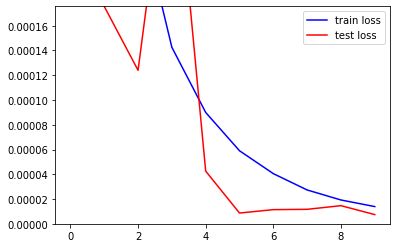

-------------STARTING EPOCH 11-------------
1364/1364 [==============================] - 15s 11ms/step - loss: 1.0077e-05 - linear_regression_equality: 0.1500 - val_loss: 2.5844e-05 - val_linear_regression_equality: 0.0305


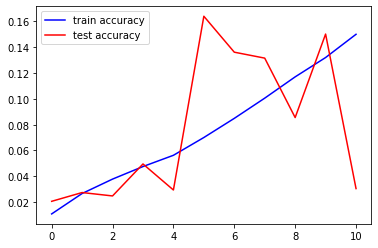

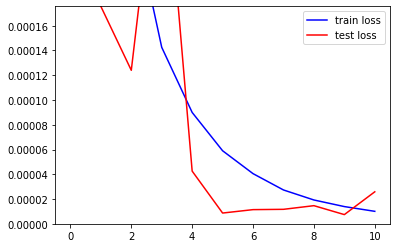

-------------STARTING EPOCH 12-------------
1364/1364 [==============================] - 15s 11ms/step - loss: 7.6009e-06 - linear_regression_equality: 0.1702 - val_loss: 5.7367e-06 - val_linear_regression_equality: 0.1621


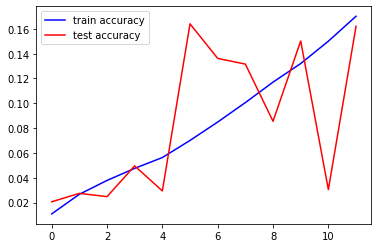

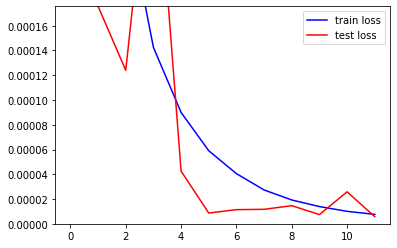

-------------STARTING EPOCH 13-------------
1364/1364 [==============================] - 15s 11ms/step - loss: 5.8160e-06 - linear_regression_equality: 0.1921 - val_loss: 3.2332e-06 - val_linear_regression_equality: 0.2401


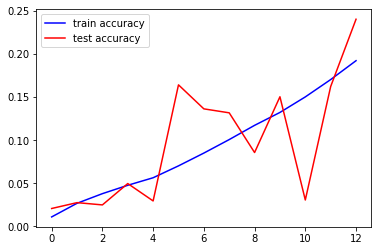

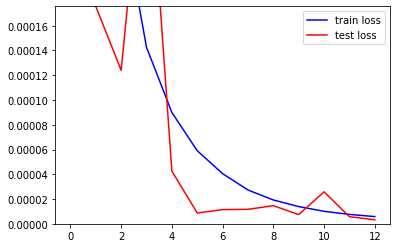

-------------STARTING EPOCH 14-------------
1364/1364 [==============================] - 15s 11ms/step - loss: 4.4905e-06 - linear_regression_equality: 0.2174 - val_loss: 4.8354e-06 - val_linear_regression_equality: 0.2033


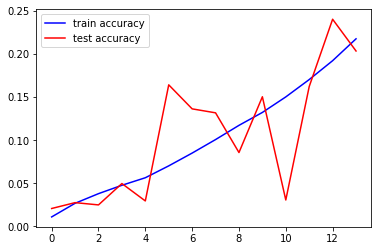

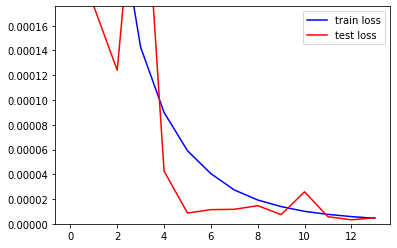

-------------STARTING EPOCH 15-------------
1364/1364 [==============================] - 15s 11ms/step - loss: 3.6189e-06 - linear_regression_equality: 0.2382 - val_loss: 2.3996e-06 - val_linear_regression_equality: 0.2711


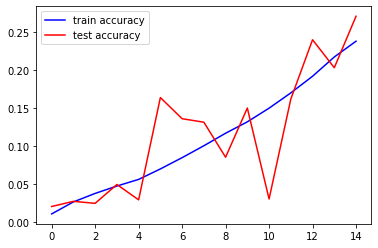

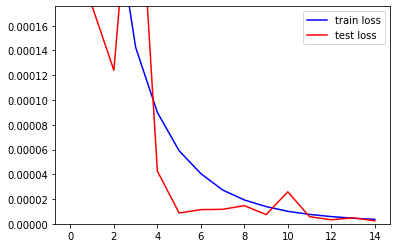

-------------STARTING EPOCH 16-------------
1364/1364 [==============================] - 15s 11ms/step - loss: 3.0439e-06 - linear_regression_equality: 0.2612 - val_loss: 2.7444e-06 - val_linear_regression_equality: 0.2474


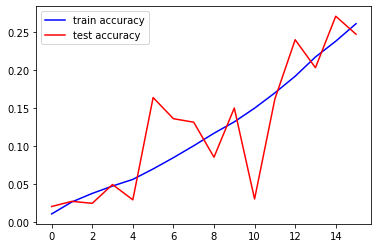

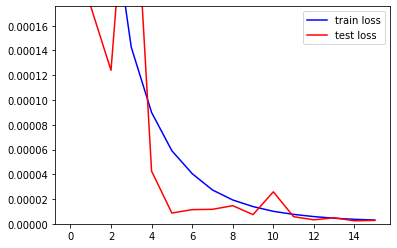

-------------STARTING EPOCH 17-------------
1364/1364 [==============================] - 15s 11ms/step - loss: 2.5900e-06 - linear_regression_equality: 0.2789 - val_loss: 2.0342e-06 - val_linear_regression_equality: 0.2917


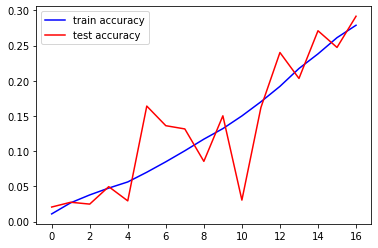

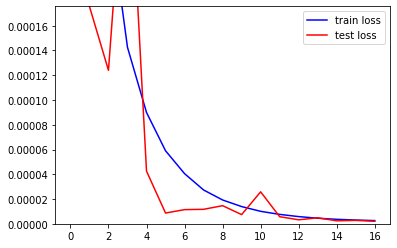

-------------STARTING EPOCH 18-------------
1364/1364 [==============================] - 15s 11ms/step - loss: 2.2545e-06 - linear_regression_equality: 0.2938 - val_loss: 2.4557e-06 - val_linear_regression_equality: 0.2702


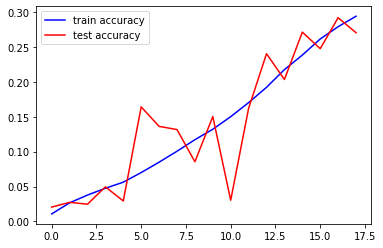

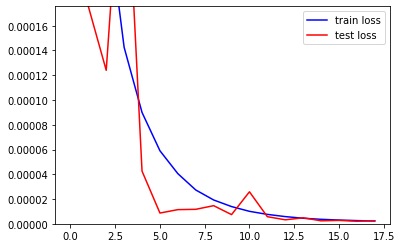

-------------STARTING EPOCH 19-------------
1364/1364 [==============================] - 15s 11ms/step - loss: 2.0193e-06 - linear_regression_equality: 0.3094 - val_loss: 2.3543e-06 - val_linear_regression_equality: 0.2774


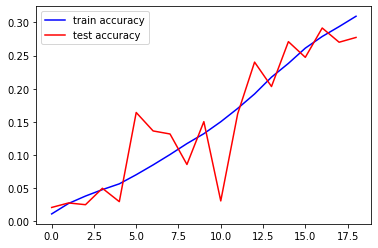

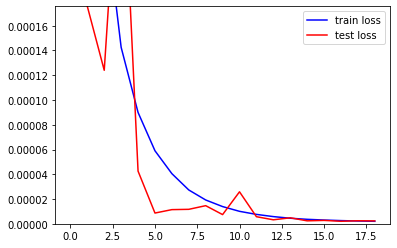

-------------STARTING EPOCH 20-------------
1364/1364 [==============================] - 16s 11ms/step - loss: 1.8396e-06 - linear_regression_equality: 0.3230 - val_loss: 2.8936e-06 - val_linear_regression_equality: 0.2559
SAVING NETWORK


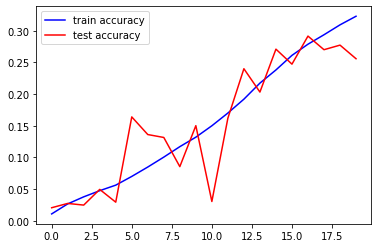

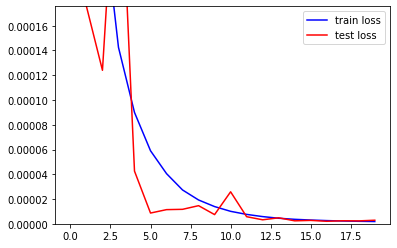

-------------STARTING EPOCH 21-------------
1364/1364 [==============================] - 16s 11ms/step - loss: 1.7119e-06 - linear_regression_equality: 0.3362 - val_loss: 2.0941e-06 - val_linear_regression_equality: 0.3123


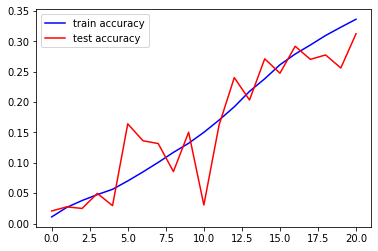

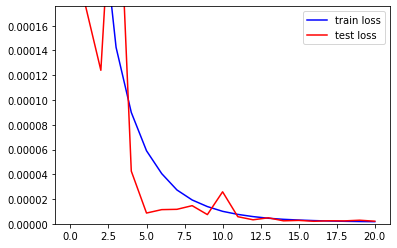

-------------STARTING EPOCH 22-------------
1364/1364 [==============================] - 15s 11ms/step - loss: 1.6055e-06 - linear_regression_equality: 0.3416 - val_loss: 1.7065e-06 - val_linear_regression_equality: 0.3327


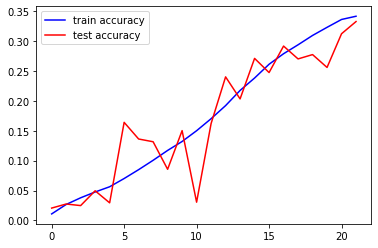

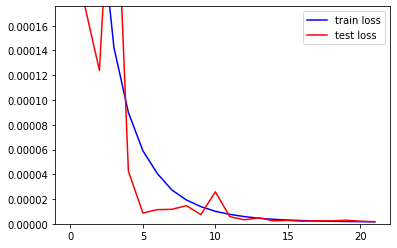

-------------STARTING EPOCH 23-------------
1364/1364 [==============================] - 15s 11ms/step - loss: 1.5383e-06 - linear_regression_equality: 0.3512 - val_loss: 1.6295e-06 - val_linear_regression_equality: 0.3307


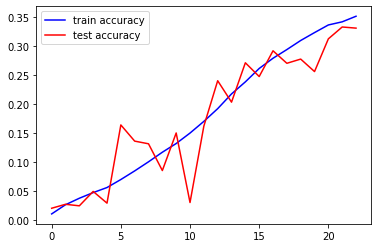

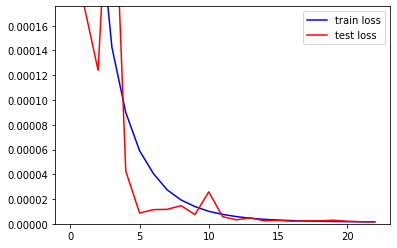

-------------STARTING EPOCH 24-------------
1364/1364 [==============================] - 16s 11ms/step - loss: 1.4897e-06 - linear_regression_equality: 0.3592 - val_loss: 1.7301e-06 - val_linear_regression_equality: 0.3307


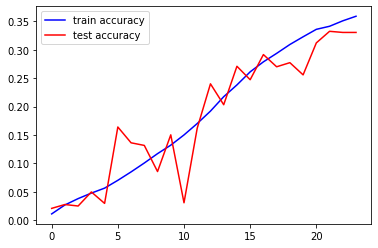

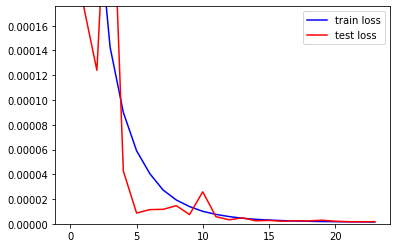

-------------STARTING EPOCH 25-------------
1364/1364 [==============================] - 16s 11ms/step - loss: 1.4327e-06 - linear_regression_equality: 0.3652 - val_loss: 1.7428e-06 - val_linear_regression_equality: 0.3259


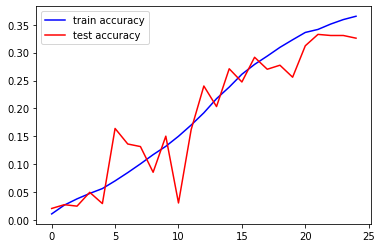

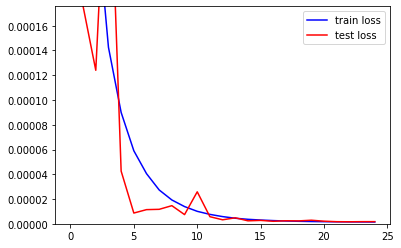

-------------STARTING EPOCH 26-------------
1364/1364 [==============================] - 16s 11ms/step - loss: 1.3967e-06 - linear_regression_equality: 0.3709 - val_loss: 1.5688e-06 - val_linear_regression_equality: 0.3465


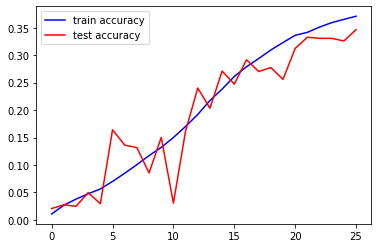

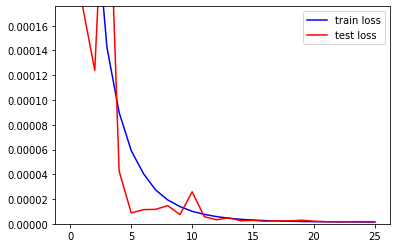

-------------STARTING EPOCH 27-------------
1364/1364 [==============================] - 15s 11ms/step - loss: 1.3678e-06 - linear_regression_equality: 0.3726 - val_loss: 1.5552e-06 - val_linear_regression_equality: 0.3493


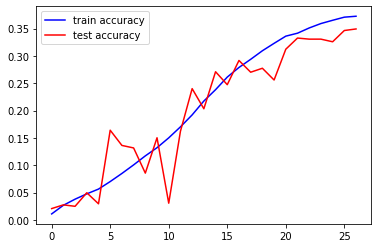

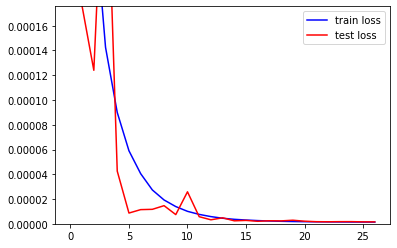

-------------STARTING EPOCH 28-------------
1364/1364 [==============================] - 16s 11ms/step - loss: 1.3455e-06 - linear_regression_equality: 0.3744 - val_loss: 1.5345e-06 - val_linear_regression_equality: 0.3485


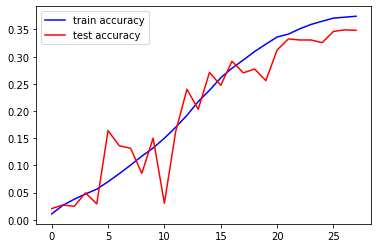

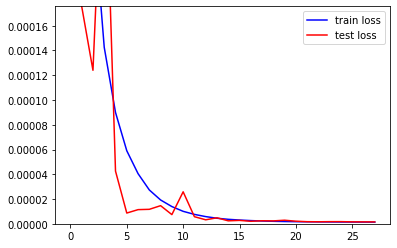

-------------STARTING EPOCH 29-------------
1364/1364 [==============================] - 16s 11ms/step - loss: 1.3259e-06 - linear_regression_equality: 0.3798 - val_loss: 1.5299e-06 - val_linear_regression_equality: 0.3485


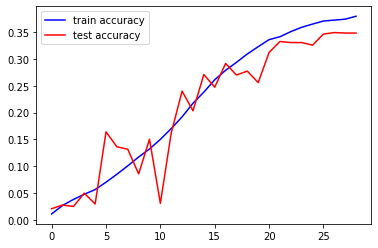

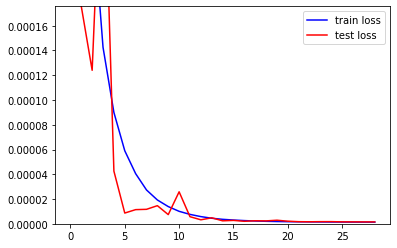

-------------STARTING EPOCH 30-------------
1364/1364 [==============================] - 16s 11ms/step - loss: 1.3092e-06 - linear_regression_equality: 0.3820 - val_loss: 1.5108e-06 - val_linear_regression_equality: 0.3570
SAVING NETWORK


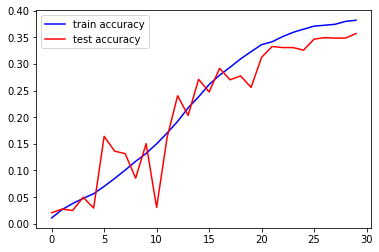

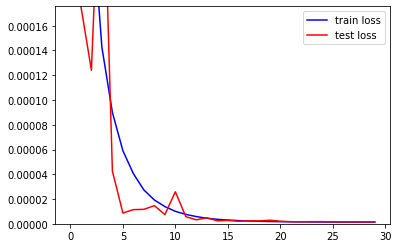

-------------STARTING EPOCH 31-------------
1364/1364 [==============================] - 16s 11ms/step - loss: 1.2965e-06 - linear_regression_equality: 0.3851 - val_loss: 1.5457e-06 - val_linear_regression_equality: 0.3614


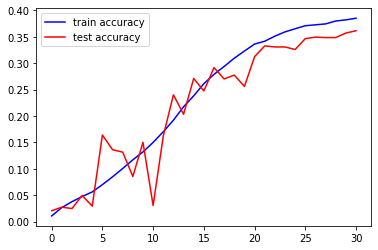

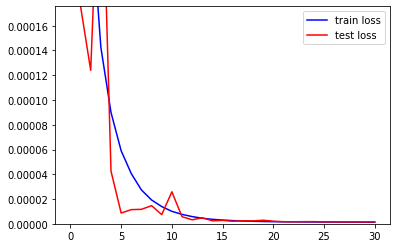

-------------STARTING EPOCH 32-------------
1364/1364 [==============================] - 16s 11ms/step - loss: 1.2867e-06 - linear_regression_equality: 0.3855 - val_loss: 1.5366e-06 - val_linear_regression_equality: 0.3493


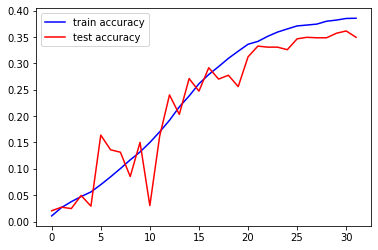

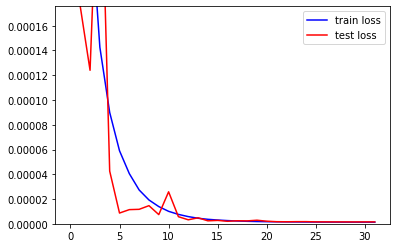

-------------STARTING EPOCH 33-------------
1364/1364 [==============================] - 16s 11ms/step - loss: 1.2769e-06 - linear_regression_equality: 0.3863 - val_loss: 1.4835e-06 - val_linear_regression_equality: 0.3590


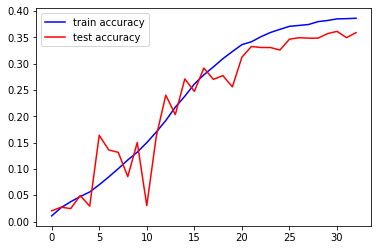

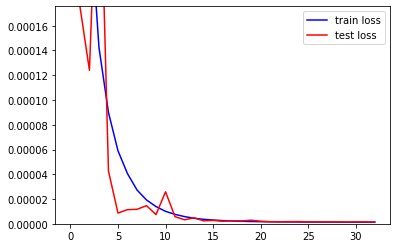

-------------STARTING EPOCH 34-------------
1364/1364 [==============================] - 16s 11ms/step - loss: 1.2708e-06 - linear_regression_equality: 0.3862 - val_loss: 1.4869e-06 - val_linear_regression_equality: 0.3579


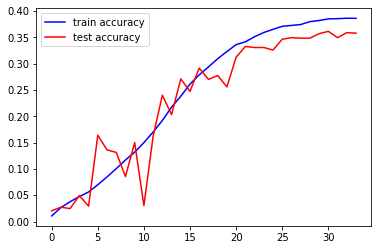

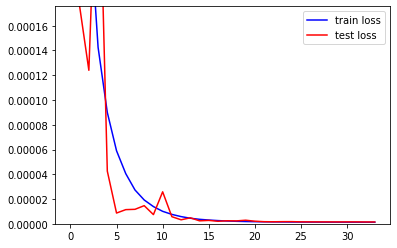

-------------STARTING EPOCH 35-------------
1364/1364 [==============================] - 16s 11ms/step - loss: 1.2650e-06 - linear_regression_equality: 0.3868 - val_loss: 1.5184e-06 - val_linear_regression_equality: 0.3535


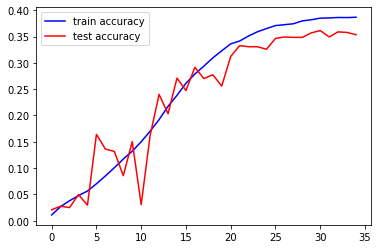

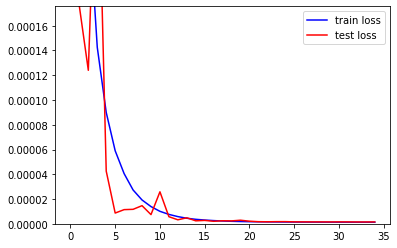

-------------STARTING EPOCH 36-------------
1364/1364 [==============================] - 16s 11ms/step - loss: 1.2594e-06 - linear_regression_equality: 0.3867 - val_loss: 1.4870e-06 - val_linear_regression_equality: 0.3555


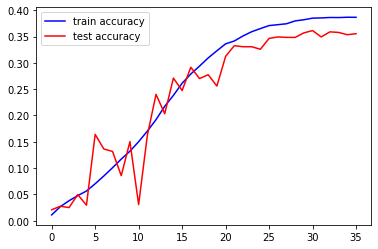

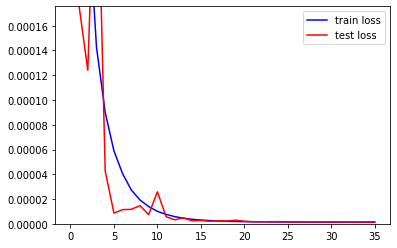

-------------STARTING EPOCH 37-------------
1364/1364 [==============================] - 16s 11ms/step - loss: 1.2568e-06 - linear_regression_equality: 0.3878 - val_loss: 1.4800e-06 - val_linear_regression_equality: 0.3601


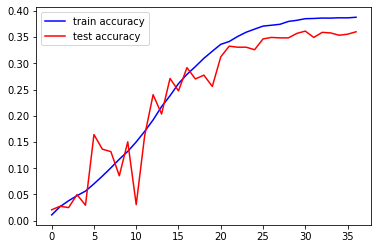

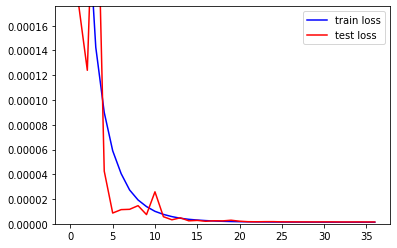

-------------STARTING EPOCH 38-------------
1364/1364 [==============================] - 16s 11ms/step - loss: 1.2514e-06 - linear_regression_equality: 0.3898 - val_loss: 1.4752e-06 - val_linear_regression_equality: 0.3581


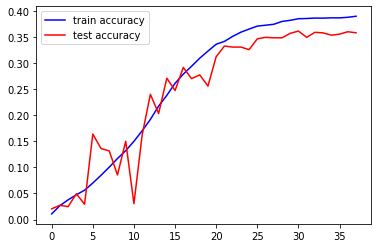

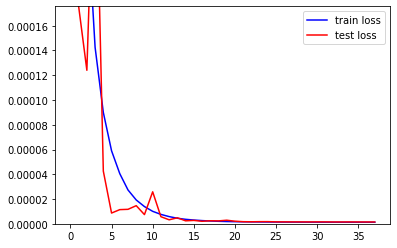

-------------STARTING EPOCH 39-------------
1364/1364 [==============================] - 16s 11ms/step - loss: 1.2489e-06 - linear_regression_equality: 0.3893 - val_loss: 1.4844e-06 - val_linear_regression_equality: 0.3566


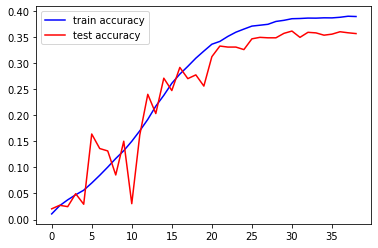

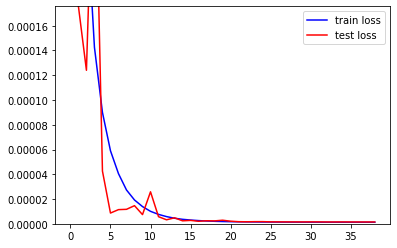

-------------STARTING EPOCH 40-------------
1364/1364 [==============================] - 16s 11ms/step - loss: 1.2473e-06 - linear_regression_equality: 0.3907 - val_loss: 1.4730e-06 - val_linear_regression_equality: 0.3621
SAVING NETWORK


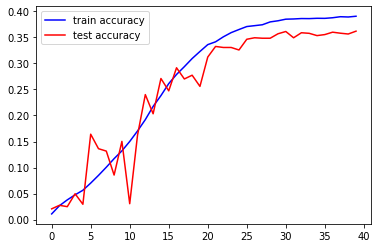

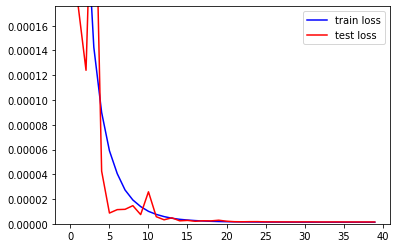

-------------STARTING EPOCH 41-------------
1364/1364 [==============================] - 16s 11ms/step - loss: 1.2446e-06 - linear_regression_equality: 0.3908 - val_loss: 1.4717e-06 - val_linear_regression_equality: 0.3590


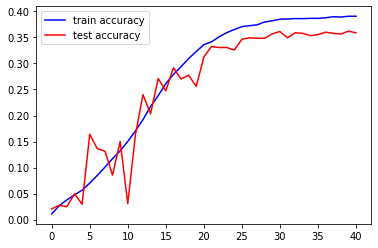

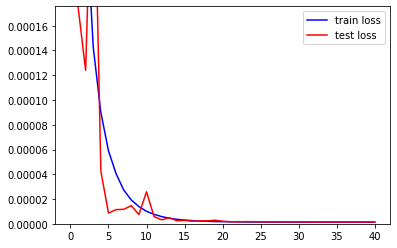

-------------STARTING EPOCH 42-------------
1364/1364 [==============================] - 16s 11ms/step - loss: 1.2437e-06 - linear_regression_equality: 0.3911 - val_loss: 1.4737e-06 - val_linear_regression_equality: 0.3612


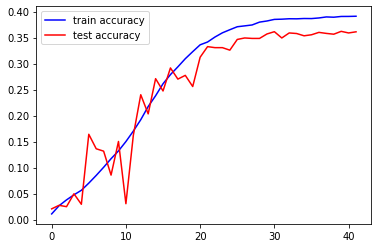

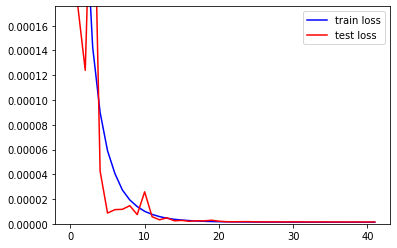

-------------STARTING EPOCH 43-------------
1364/1364 [==============================] - 16s 11ms/step - loss: 1.2417e-06 - linear_regression_equality: 0.3914 - val_loss: 1.4713e-06 - val_linear_regression_equality: 0.3577


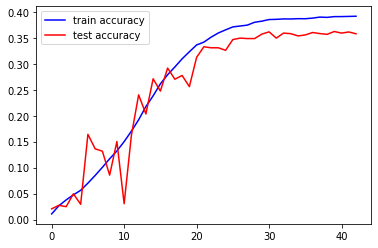

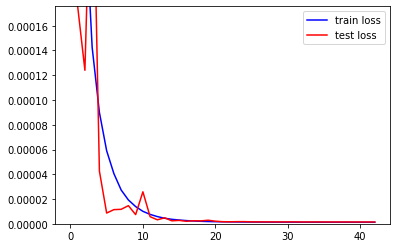

-------------STARTING EPOCH 44-------------
1364/1364 [==============================] - 16s 11ms/step - loss: 1.2402e-06 - linear_regression_equality: 0.3913 - val_loss: 1.4751e-06 - val_linear_regression_equality: 0.3623


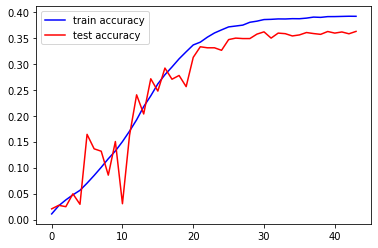

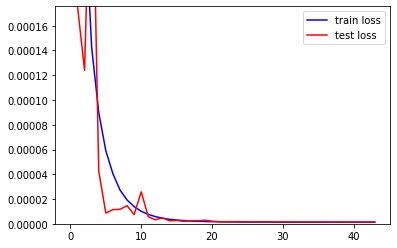

-------------STARTING EPOCH 45-------------
1364/1364 [==============================] - 16s 11ms/step - loss: 1.2397e-06 - linear_regression_equality: 0.3905 - val_loss: 1.4716e-06 - val_linear_regression_equality: 0.3588


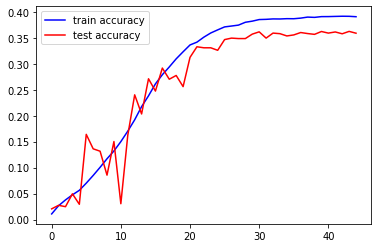

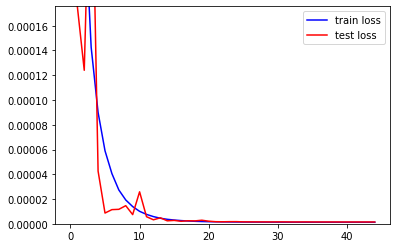

In [30]:
epoch_to_load = int(input("what epoch to load?"))
base_type = int(input("Normal base (0)? or Inverse Square base (1)?"))
if epoch_to_load == 0:
  #Building and compiling CNN
  model = compile_cnn(build_cnn_model(),0.001)
  #Defining a decaying learning rate
  epoch_to_save = 10
else:
  model = load_model(epoch_to_load)
  epoch_to_save = 5
print("Model has been compiled")

EPOCHS = int(input("how many epochs to train?"))
#EPOCHS = 150

#Defining lists to store accuracy and loss values over the course of training 
accuracy_values = []
validation_accuracy_values= []
loss_values = []
validation_loss_values = []



#Training Neural Net
for epoch in range(epoch_to_load+1,epoch_to_load+EPOCHS+1):
  
  print("-------------STARTING EPOCH {}-------------".format(epoch))
  history = model.fit(X_array,Y_array,batch_size=30,epochs=1,validation_split=0.1)
  #Storing accuracy and loss values
  accuracy_values.append(history.history['linear_regression_equality'][0])
  validation_accuracy_values.append(history.history['val_linear_regression_equality'][0])
  loss_values.append(history.history['loss'][0])
  validation_loss_values.append(history.history['val_loss'][0])

  if epoch % epoch_to_save == 0:    
    print("SAVING NETWORK")
    if base_type == 0:
      weights_file_name = "/content/drive/MyDrive/Bismuth_Data_Processed/CNN_weights_normal_{}.ckpt".format(epoch)
    elif base_type == 1:
      weights_file_name = "/content/drive/MyDrive/Bismuth_Data_Processed/CNN_weights_inv_sq_{}.ckpt".format(epoch)
    else:
      weights_file_name = "/content/drive/MyDrive/Bismuth_Data_Processed/CNN_weights_unspecified_fn_{}.ckpt".format(epoch)
    model.save_weights(weights_file_name)
  if epoch > epoch_to_load + 1:
    #Plotting NN performance
    f1 = plt.figure()
    f2 = plt.figure()
    ax1 = f1.add_subplot(111)

    ax1.plot(accuracy_values, "-b",label = "train accuracy")
    ax1.plot(validation_accuracy_values, "-r",label = "test accuracy")
    ax1.legend()
    ax2 = f2.add_subplot(111)
    ax2.plot(loss_values, "-b",label = "train loss")
    ax2.plot(validation_loss_values, "-r",label = "test loss")
    ax2.set_ylim([0,validation_loss_values[1]])
    ax2.legend()
    plt.show()




Directory name: /content/drive/MyDrive/Bismuth_Data_Processed/2021-02-16/scans/scan0/
Done! Added 11 images


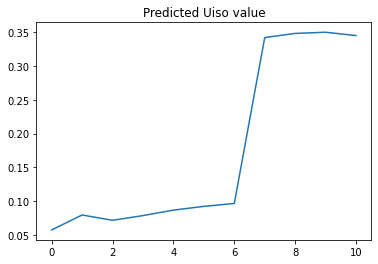

Directory name: /content/drive/MyDrive/Bismuth_Data_Processed/2021-02-16/scans/scan1/
Done! Added 11 images


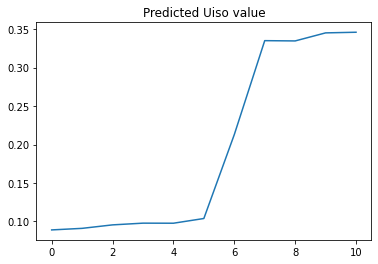

Directory name: /content/drive/MyDrive/Bismuth_Data_Processed/2021-02-16/scans/scan2/
Done! Added 21 images


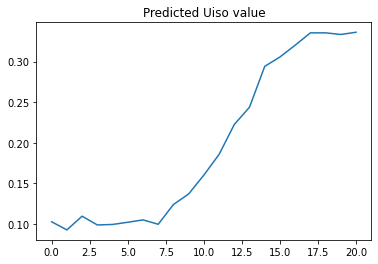

Directory name: /content/drive/MyDrive/Bismuth_Data_Processed/2021-02-16/scans/scan3/
Done! Added 41 images


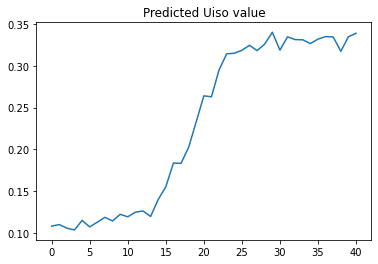

Directory name: /content/drive/MyDrive/Bismuth_Data_Processed/2021-02-16/scans/scan4/
Done! Added 51 images


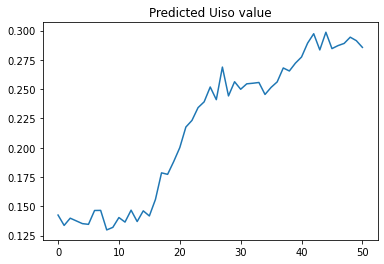

Directory name: /content/drive/MyDrive/Bismuth_Data_Processed/2021-02-16/scans/scan5/
Done! Added 11 images


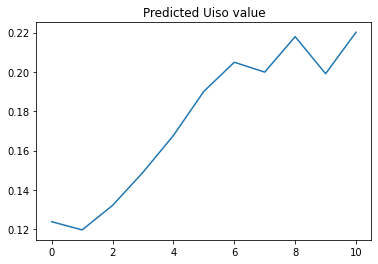

Directory name: /content/drive/MyDrive/Bismuth_Data_Processed/2021-02-16/scans/scan6/
Done! Added 41 images


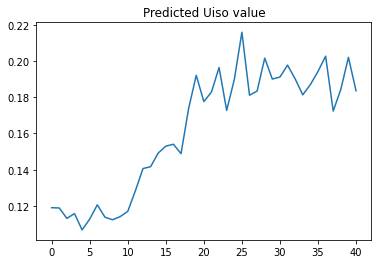

7
7
7
7
7
7
7


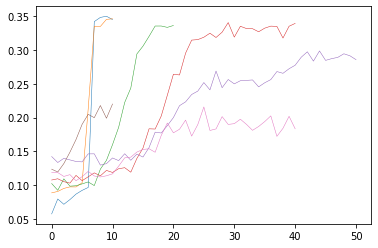

Directory name: /content/drive/MyDrive/Bismuth_Data_Processed/2021-02-17/scans/scan0/
Done! Added 0 images
Couldn't load
Directory name: /content/drive/MyDrive/Bismuth_Data_Processed/2021-02-17/scans/scan7/
Done! Added 6 images


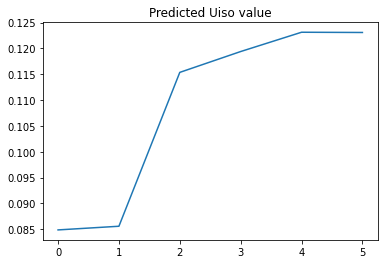

Directory name: /content/drive/MyDrive/Bismuth_Data_Processed/2021-02-17/scans/scan8/
Done! Added 40 images


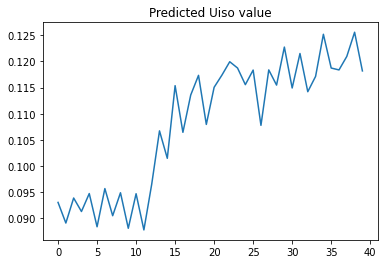

Directory name: /content/drive/MyDrive/Bismuth_Data_Processed/2021-02-17/scans/scan10/
Done! Added 6 images


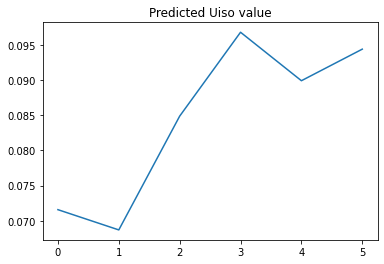

Directory name: /content/drive/MyDrive/Bismuth_Data_Processed/2021-02-17/scans/scan11/
Done! Added 41 images


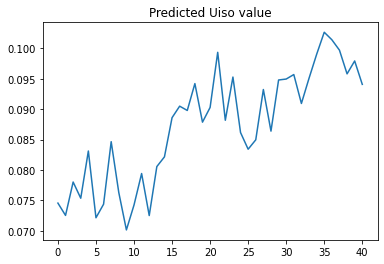

Directory name: /content/drive/MyDrive/Bismuth_Data_Processed/2021-02-17/scans/scan12/
Done! Added 5 images


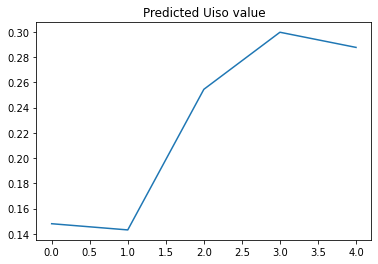

Directory name: /content/drive/MyDrive/Bismuth_Data_Processed/2021-02-17/scans/scan13/
Done! Added 41 images


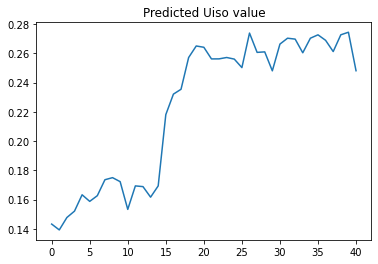

Directory name: /content/drive/MyDrive/Bismuth_Data_Processed/2021-02-17/scans/scan14/
Done! Added 5 images


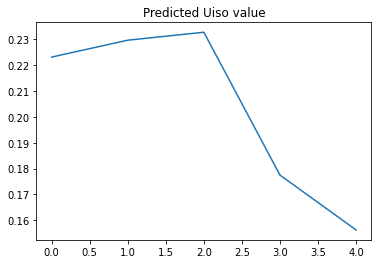

7
7
7
7
7
7
7


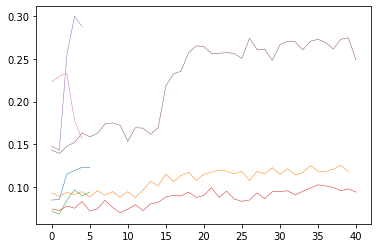

Directory name: /content/drive/MyDrive/Bismuth_Data_Processed/2021-02-21/scans/scan0/
Done! Added 9 images


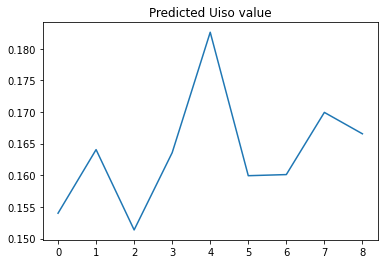

Directory name: /content/drive/MyDrive/Bismuth_Data_Processed/2021-02-21/scans/scan1/
Done! Added 11 images


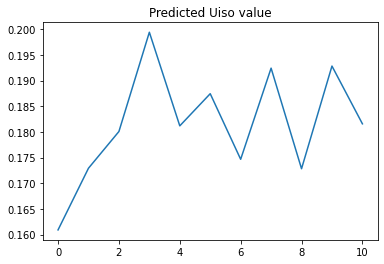

Directory name: /content/drive/MyDrive/Bismuth_Data_Processed/2021-02-21/scans/scan2/
Done! Added 13 images


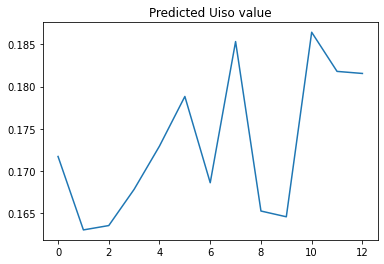

Directory name: /content/drive/MyDrive/Bismuth_Data_Processed/2021-02-21/scans/scan3/
Done! Added 15 images


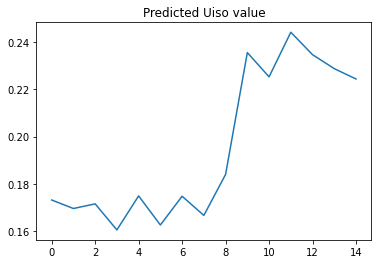

Directory name: /content/drive/MyDrive/Bismuth_Data_Processed/2021-02-21/scans/scan4/
Done! Added 16 images


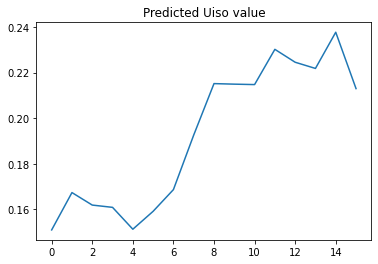

Directory name: /content/drive/MyDrive/Bismuth_Data_Processed/2021-02-21/scans/scan5/
Done! Added 24 images


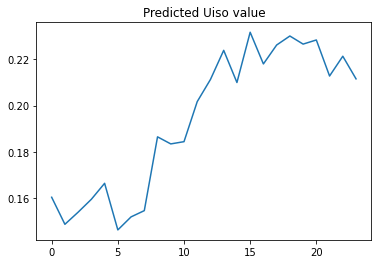

Directory name: /content/drive/MyDrive/Bismuth_Data_Processed/2021-02-21/scans/scan6/
Done! Added 22 images


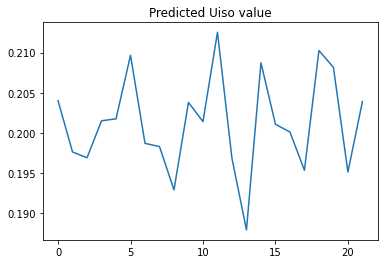

Directory name: /content/drive/MyDrive/Bismuth_Data_Processed/2021-02-21/scans/scan7/
Done! Added 1 images
Directory name: /content/drive/MyDrive/Bismuth_Data_Processed/2021-02-21/scans/scan8/
Done! Added 1 images
Directory name: /content/drive/MyDrive/Bismuth_Data_Processed/2021-02-21/scans/scan9/
Done! Added 1 images
Directory name: /content/drive/MyDrive/Bismuth_Data_Processed/2021-02-21/scans/scan10/
Done! Added 24 images


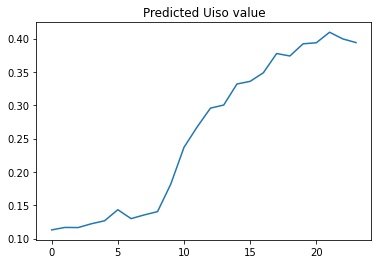

Directory name: /content/drive/MyDrive/Bismuth_Data_Processed/2021-02-21/scans/scan12/
Done! Added 25 images


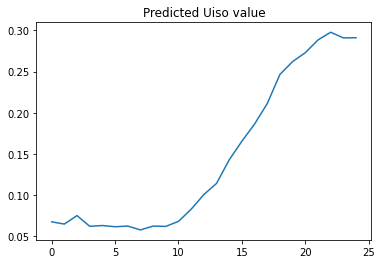

Directory name: /content/drive/MyDrive/Bismuth_Data_Processed/2021-02-21/scans/scan13/
Done! Added 25 images


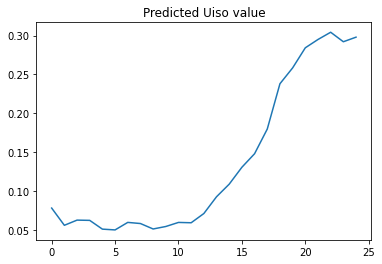

Directory name: /content/drive/MyDrive/Bismuth_Data_Processed/2021-02-21/scans/scan14/
Done! Added 25 images


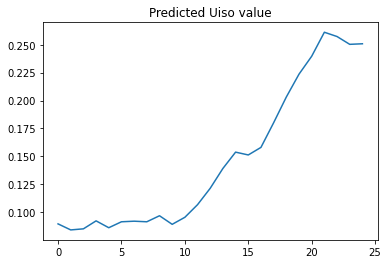

11
11
11
11
11
11
11
11
11
11
11


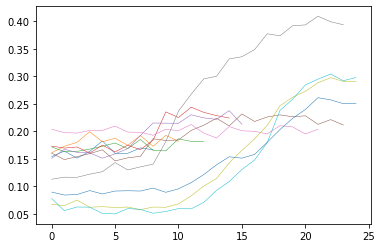

In [34]:
epoch_to_load = int(input("what epoch to load?"))
base_type = int(input("Normal base (0)? or Inverse Square base (1)?"))
model = load_model(epoch_to_load,base_type)


#array of dates of scans to be opened
dates = [16,17,21]


Y,X = np.ogrid[:resolution,:resolution]
centre_val = resolution/2

dist_from_center = np.sqrt((X-78)**2+(Y-79)**2)
mask = (dist_from_center > 13)      

#opens scans 0-15
dirs_to_open=range(0,15)
data_dir = '/content/drive/MyDrive/Bismuth_Data_Processed/'
for date in dates:
  date = "2021-02-" + str(date) + "/scans/scan"
  series_arr = []
  for i in dirs_to_open:
    #print("----------STARTING NEW TEST------")
    scan_num = str(i)
    dir_name = data_dir + date + scan_num + "/"
    if os.path.exists(dir_name):
      print("Directory name: "+dir_name)
      file_name_array, data_dict = process_data(dir_name)
      file_name_array.sort()
      data_arr = []


      for file_name in file_name_array:
        data_arr.append([data_dict[file_name],file_name])     
        

      try:
        X_test,labels = zip(*data_arr)        
        X_test_arr = np.expand_dims(np.array(X_test),-1)
        predictions = model.predict(X_test_arr)
        reg_preds = []
        for prediction in predictions:
          reg_preds.append(prediction)
        if len(reg_preds) > 1:
          series_arr.append(reg_preds)
          
          plt.plot(reg_preds)
          plt.title("Predicted Uiso value")
          plt.show()          
                      
        #if i train for many epochs, maybe it overfits because of relatively small basis of original data points in dataset, but trend of predicted uiso values doesn't show any increase
      except:
        print("Couldn't load")
      
  
  #plt.title("Predicted Uiso value")
  for series in series_arr:
    print(len(series_arr))
    plt.plot(series, linewidth=0.5)
  plt.show()
  


Directory name: /content/drive/MyDrive/Bismuth_Data_Processed/2021-02-16/scans/scan0/
Done! Added 11 images


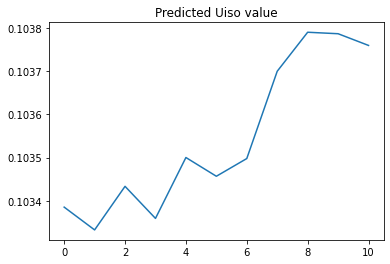

Directory name: /content/drive/MyDrive/Bismuth_Data_Processed/2021-02-16/scans/scan1/
Done! Added 11 images


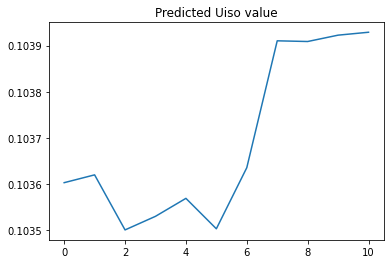

Directory name: /content/drive/MyDrive/Bismuth_Data_Processed/2021-02-16/scans/scan2/
Done! Added 21 images


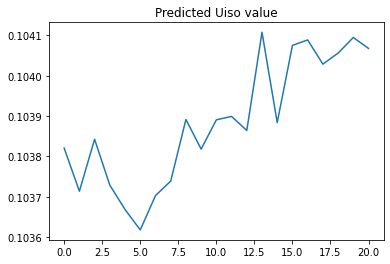

Directory name: /content/drive/MyDrive/Bismuth_Data_Processed/2021-02-16/scans/scan3/
Done! Added 41 images


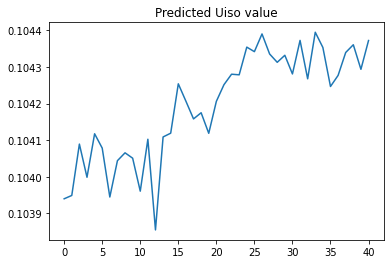

Directory name: /content/drive/MyDrive/Bismuth_Data_Processed/2021-02-16/scans/scan4/
Done! Added 51 images


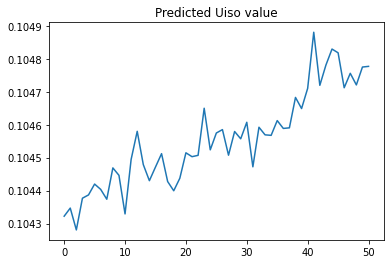

Directory name: /content/drive/MyDrive/Bismuth_Data_Processed/2021-02-16/scans/scan5/
Done! Added 11 images


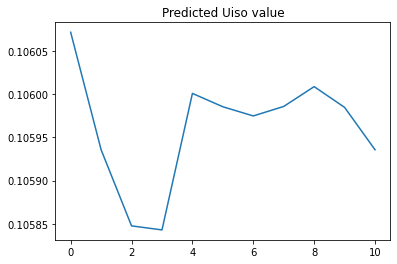

Directory name: /content/drive/MyDrive/Bismuth_Data_Processed/2021-02-16/scans/scan6/
Done! Added 41 images


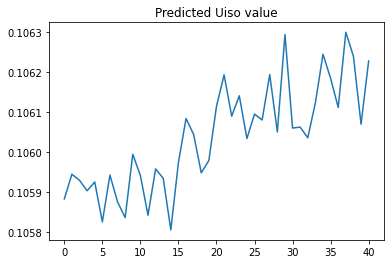

Directory name: /content/drive/MyDrive/Bismuth_Data_Processed/2021-02-17/scans/scan0/
Done! Added 0 images
Couldn't load
Directory name: /content/drive/MyDrive/Bismuth_Data_Processed/2021-02-17/scans/scan7/
Done! Added 6 images


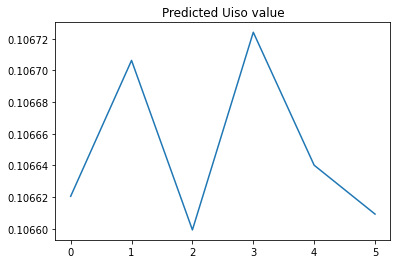

Directory name: /content/drive/MyDrive/Bismuth_Data_Processed/2021-02-17/scans/scan8/
Done! Added 40 images


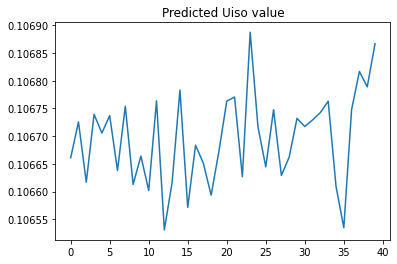

Directory name: /content/drive/MyDrive/Bismuth_Data_Processed/2021-02-17/scans/scan10/
Done! Added 6 images


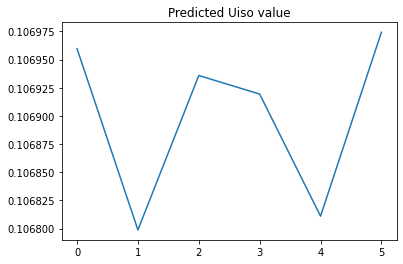

Directory name: /content/drive/MyDrive/Bismuth_Data_Processed/2021-02-17/scans/scan11/
Done! Added 41 images


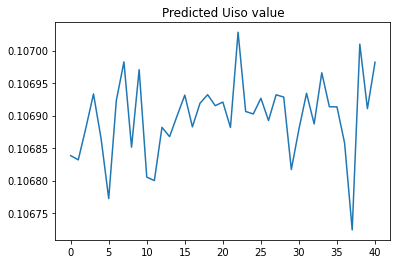

Directory name: /content/drive/MyDrive/Bismuth_Data_Processed/2021-02-17/scans/scan12/
Done! Added 5 images


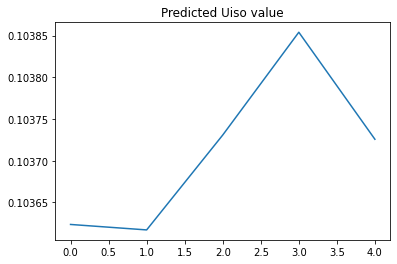

Directory name: /content/drive/MyDrive/Bismuth_Data_Processed/2021-02-17/scans/scan13/
Done! Added 41 images


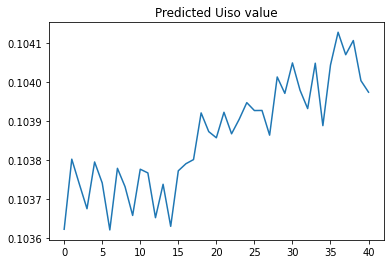

Directory name: /content/drive/MyDrive/Bismuth_Data_Processed/2021-02-17/scans/scan14/
Done! Added 5 images


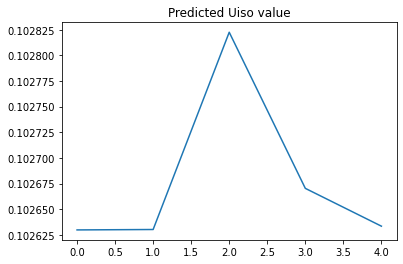

Directory name: /content/drive/MyDrive/Bismuth_Data_Processed/2021-02-21/scans/scan0/
Done! Added 9 images


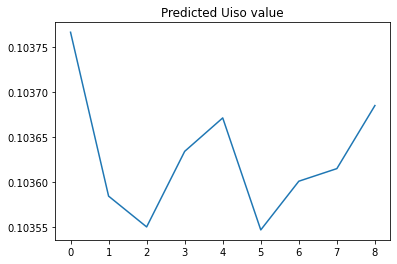

Directory name: /content/drive/MyDrive/Bismuth_Data_Processed/2021-02-21/scans/scan1/
Done! Added 11 images


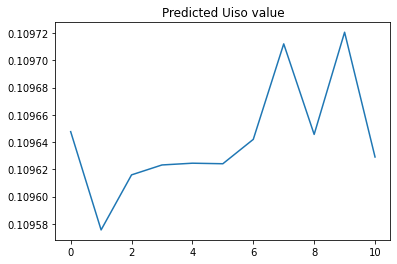

Directory name: /content/drive/MyDrive/Bismuth_Data_Processed/2021-02-21/scans/scan2/
Done! Added 13 images


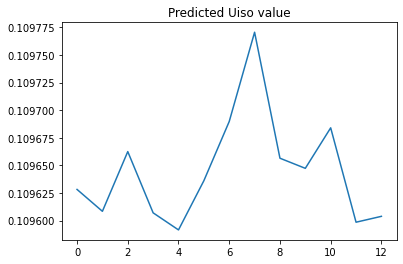

Directory name: /content/drive/MyDrive/Bismuth_Data_Processed/2021-02-21/scans/scan3/
Done! Added 15 images


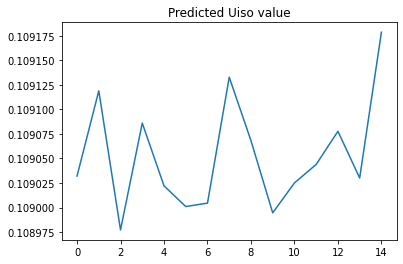

Directory name: /content/drive/MyDrive/Bismuth_Data_Processed/2021-02-21/scans/scan4/
Done! Added 16 images


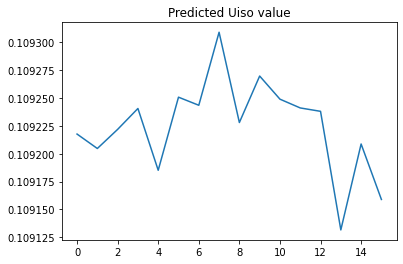

Directory name: /content/drive/MyDrive/Bismuth_Data_Processed/2021-02-21/scans/scan5/
Done! Added 24 images


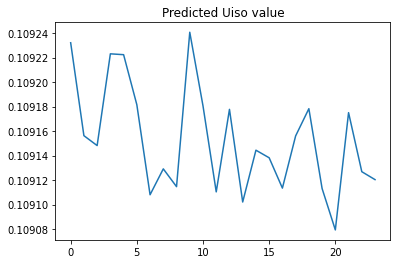

Directory name: /content/drive/MyDrive/Bismuth_Data_Processed/2021-02-21/scans/scan6/
Done! Added 22 images


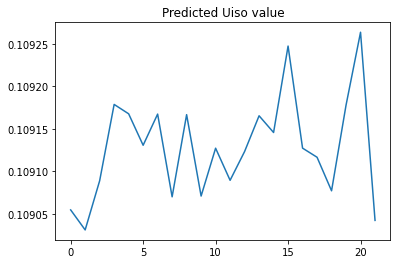

Directory name: /content/drive/MyDrive/Bismuth_Data_Processed/2021-02-21/scans/scan7/
Done! Added 1 images
Directory name: /content/drive/MyDrive/Bismuth_Data_Processed/2021-02-21/scans/scan8/
Done! Added 1 images
Directory name: /content/drive/MyDrive/Bismuth_Data_Processed/2021-02-21/scans/scan9/
Done! Added 1 images
Directory name: /content/drive/MyDrive/Bismuth_Data_Processed/2021-02-21/scans/scan10/
Done! Added 24 images


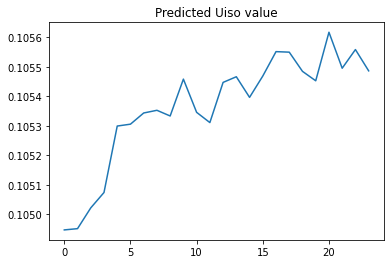

Directory name: /content/drive/MyDrive/Bismuth_Data_Processed/2021-02-21/scans/scan12/
Done! Added 25 images


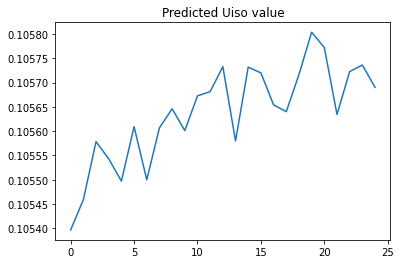

Directory name: /content/drive/MyDrive/Bismuth_Data_Processed/2021-02-21/scans/scan13/
Done! Added 25 images


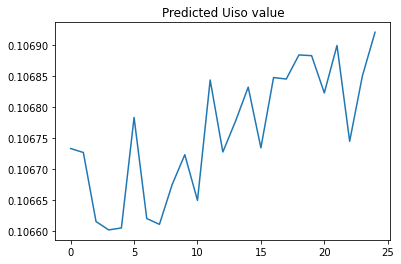

Directory name: /content/drive/MyDrive/Bismuth_Data_Processed/2021-02-21/scans/scan14/
Done! Added 25 images


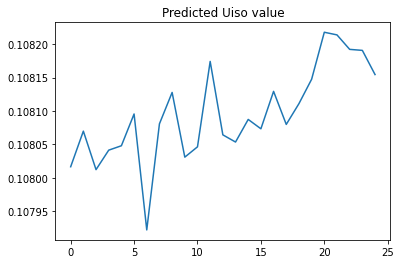

In [ ]:
#Scans from previous iteration kept as a reference